In [1]:
%matplotlib inline

import urllib.request, io, csv, math
import pandas as pd
import numpy as np
from scipy import stats, polyfit, polyval
from matplotlib import pyplot as plt


In [2]:
# get the index of datafiles on the cave logger
datafiles = None
def getbottlebatdata(i):
    global datafiles
    if datafiles is None:
        with urllib.request.urlopen("http://192.168.4.1/datastatus") as fin:
            datafiles = pd.read_csv(fin)
        print(datafiles)
    fsh = "/csvdata/%s/d" % datafiles.iloc[i].datafile
    fin = urllib.request.urlopen("http://192.168.4.1"+fsh)
    k = pd.read_csv(fin, skiprows=1, names=["time", "tmp"])
    k.tmp = k.tmp/16
    k.time = k.time*0.001
    k = k.set_index("time")
    return k


SyntaxError: invalid syntax (<ipython-input-2-f234a0f41697>, line 3)

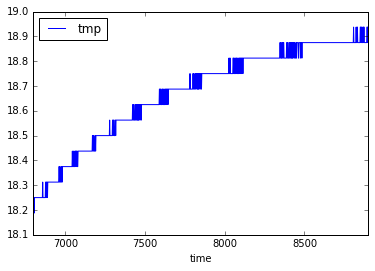

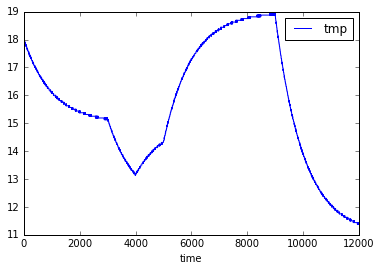

In [10]:
def generatebottlebatdata(dfac):
    svs = [15, 15, 15, 12, 15, 19, 19, 19, 19, 11, 11, 11]
    tvs = [ ]
    Ltmp = 18
    previ = 0
    for i in range(0, 12000, 2):
        Etmp = svs[int(i/1000)]
        Ltmp = Etmp + (Ltmp - Etmp)*math.exp(-(i - previ)*dfac)
        Ftmp = int(Ltmp*16 + ((i**2 % 21)-10)/45 + 0.5)/16  # filter to 16ths with noise
        tvs.append({"time":float(i), "tmp":Ftmp})
        previ = i
    k = pd.DataFrame.from_dict(tvs)
    k = k.set_index("time")
    return k
k = generatebottlebatdata(0.001)
k[6800:8900].plot()
k.plot()


array([  0.09452867,  18.99750591])

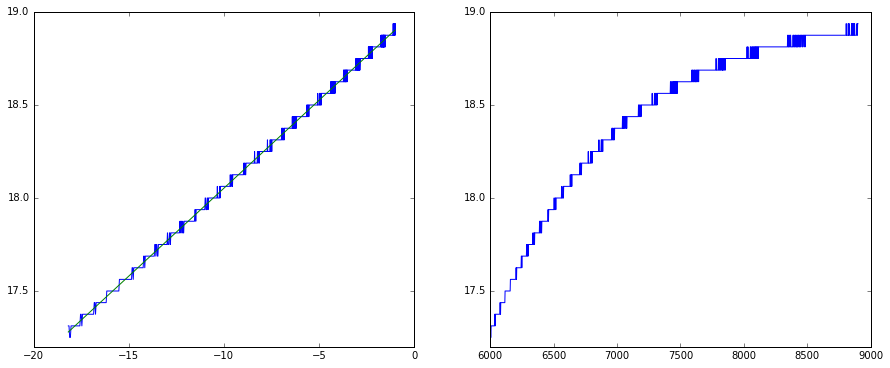

In [9]:
# slice temperature data within one curve
afac = 0.001
l = k[6000:8900]
letime = -np.exp((l.index[-1] - l.index)*fac)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(letime, l.tmp)
pf = polyfit(letime, l.tmp, 1)
plt.plot(letime, polyval(pf, letime))

plt.subplot(122)
plt.plot(l.index, l.tmp)
pf



In [11]:
def expLD(l, fac, fdec, lMfdec):
    Lsx, Lsx2, Lsxy, Lsy, Lsy2, Ln = 0, 0, 0, 0, 0, 0
    Lalphas, Lbetas, Lrsqs = [ ], [ ], [ ]
    Lbeta = 1
    for i in range(len(l)):
        Mfdec = lMfdec * (Lrsqs and (Lrsqs[-1]+99)/100 or 1)
        Mfdec = lMfdec/max(0.1, abs(Lbeta))
        Mfdec = lMfdec
        ef = math.exp((l.index[i] - l.index[i-1])*fac) if i != 0 else 1
        Lsx = Lsx*ef*Mfdec + fdec
        Lsx2 = Lsx2*ef**2*Mfdec + fdec
        Lsxy = Lsxy*ef*Mfdec + l.tmp.iloc[i]*fdec
        Lsy = Lsy*Mfdec + l.tmp.iloc[i]*fdec
        Lsy2 = Lsy2*Mfdec + l.tmp.iloc[i]**2*fdec
        Ln = Ln*Mfdec + fdec
        Lbeta = (Lsxy*Ln - Lsx*Lsy)/(Lsx2*Ln - Lsx**2 or 1)
        Lalpha = (Lsy - Lbeta*Lsx)/Ln
        Lrsq = (Lsxy*Ln - Lsx*Lsy)**2/((Lsx2*Ln - Lsx**2)*(Lsy2*Ln - Lsy**2) or 1)
        Lalphas.append(Lalpha)
        Lbetas.append(Lbeta)
        Lrsqs.append(Lrsq)
    return Lalphas, Lbetas, Lrsqs

# wanted to make Mfdec bigger (so the tail is shorter) as rsq gets far from 1
# but could do it to extend the tail as beta the slope gets flatter as we 
## approach the asymtote and get more effected by the noise there

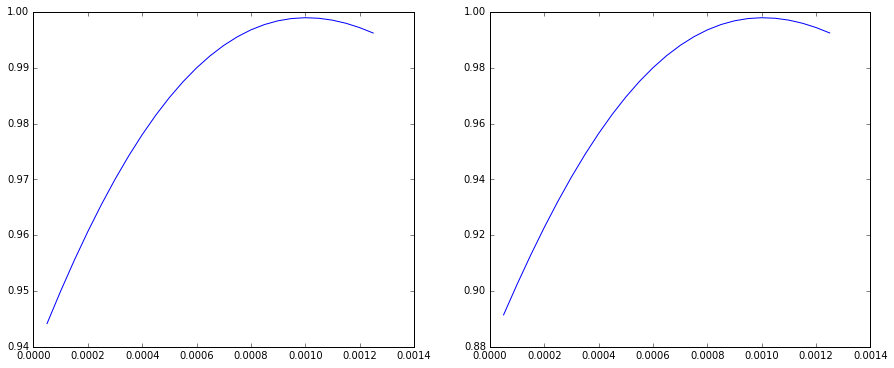

In [12]:
# what is the best fac value within this slice?
facs = [ i*0.00001  for i in range(5, 130, 5) ]
rs = [ ]
ist = [ ]
ers = [ ]
for fac in facs:
    etime = -np.exp((l.index[-1] - l.index)*fac)
    s = stats.linregress(etime, l.tmp)
    rs.append(s.rvalue)
    #ist.append(s.intercept)
    ers.append(s.stderr)
    Lalphas, Lbetas, Lrsqs = expLD(l, fac, 1, 1)
    ist.append(Lrsqs[-1])
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(facs, rs)
plt.subplot(122)
plt.plot(facs, ist)
#plt.plot(facs, ers)



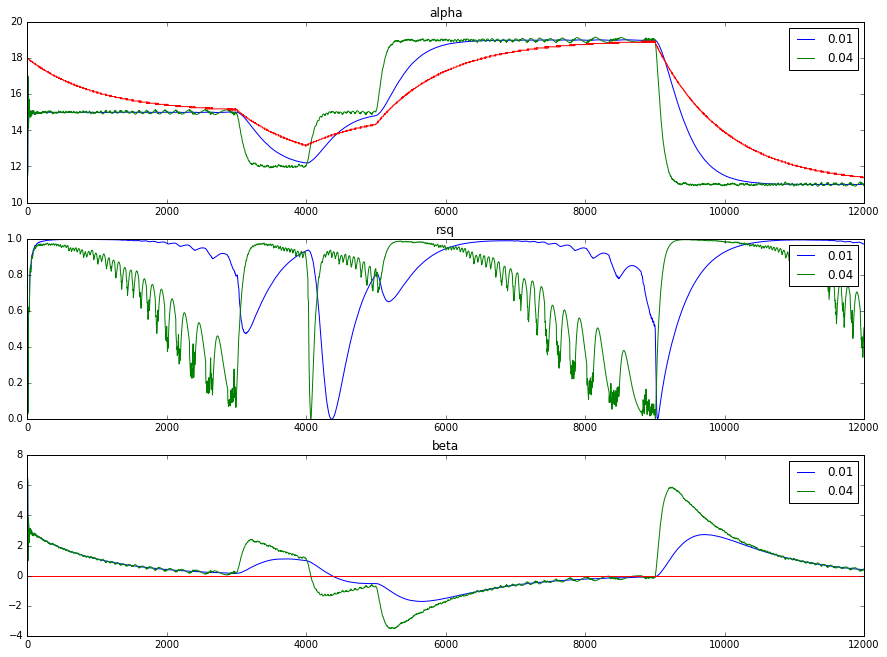

In [13]:
fac = 0.001

plt.figure(figsize=(15,11))
plt.subplot(311)

d2 = 0.04
Lalpha1, Lbeta1, Lrsqs1 = expLD(k, fac, 0.01, 1-0.01)
plt.plot(k.index, Lalpha1, label="0.01")
Lalpha2, Lbeta2, Lrsqs2 = expLD(k, fac, d2, 1-d2)
plt.plot(k.index, Lalpha2, label=str(d2))
plt.plot(k)
plt.title("alpha")
plt.legend()

plt.subplot(312)
plt.plot(k.index, Lrsqs1, label="0.01")
plt.plot(k.index, Lrsqs2, label=str(d2))
plt.title("rsq")
plt.legend()

plt.subplot(313)
plt.plot(k.index, Lbeta1, label="0.01")
plt.plot(k.index, Lbeta2, label=str(d2))
plt.plot([k.index[0], k.index[-1]], [0,0])
plt.title("beta")
plt.legend()


In [14]:
plt.title?